In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, kendalltau

from tqdm import tqdm
import random

from settings import EMBEDDINGS_PATH, FINAL_DF
from src.data.assign_emoji_categories import assign_emojipedia_category, assign_our_category
from src.analysis.variation import calculate_vocabulary_variation, embedded_CIs, read_embeddings
from src.visualization.emoji_plotting import emoji_scatter

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Compute variation and its confidence - this takes a lot of resources for bootstrapping

In [3]:
print("Reading data...")
emojis = pd.read_csv(FINAL_DF, encoding='utf-8')
word_embeddings = read_embeddings(EMBEDDINGS_PATH)

print("Preprocessing...")
vocabularies = emojis[["emoji", "word"]] \
    .groupby("emoji").word \
    .apply(list).apply(Counter) \
    .reset_index() \
    .rename({"word": "vocabulary"}, axis=1)

print("Calculating semantic variation in embedding space per emoji...")
vocabularies[["variation", "mode_embedding"]] = vocabularies.apply(lambda row:
                                                                   calculate_vocabulary_variation(row.vocabulary,
                                                                                                  word_embeddings),
                                                                   axis=1,
                                                                   result_type='expand')

print("Bootstrapping...")
CIs = vocabularies.parallel_apply(lambda row: embedded_CIs(calculate_vocabulary_variation,
                                         row.vocabulary, row.mode_embedding,
                                         word_embeddings),
                            axis=1)
vocabularies["CIs"] = CIs
variations = vocabularies

flags = [ '🏳️', "🏳️‍🌈", "🏴‍☠️" , "🏴󠁧󠁢󠁥󠁮󠁧󠁿" , "🏴󠁧󠁢󠁳󠁣󠁴󠁿", "🏴󠁧󠁢󠁷󠁬󠁳󠁿" ]
families = ["👨‍👦","👨‍👦‍👦","👨‍👧","👨‍👧‍👦","👨‍👧‍👧","👨‍👨‍👦","👨‍👨‍👦‍👦","👨‍👨‍👧","👨‍👨‍👧‍👦",\
"👨‍👨‍👧‍👧","👨‍👩‍👦","👨‍👩‍👦‍👦","👨‍👩‍👧","👨‍👩‍👧‍👦","👨‍👩‍👧‍👧","👩‍👦","👩‍👦‍👦","👩‍👧",\
"👩‍👧‍👦","👩‍👧‍👧","👩‍👩‍👦","👩‍👩‍👦‍👦","👩‍👩‍👧","👩‍👩‍👧‍👦","👩‍👩‍👧‍👧", "👨‍👩‍👧", "👨‍👩‍👧‍👦", "👨‍👩‍👧‍👧", "👩‍👩‍👧‍👦"]
variations = variations[~variations.emoji.isin(flags)]
variations = variations[~variations.emoji.isin(["🅰️", "🅱️", "🅾️", "🅿️", "🔟"])]
variations = variations[~variations.emoji.isin(families)]
variations['vocabulary size'] = variations.vocabulary.apply(len)

Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...
Bootstrapping...


/home/jczestochowska/.virtualenvs/py8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


### Create baselines

In [4]:
ambiguity = pd.read_csv(FINAL_DF, encoding='utf-8')
word_embeddings = read_embeddings(EMBEDDINGS_PATH)
words = ambiguity.word

baselines_variation, baselines_vocab_size = [], []
for i in tqdm(range(1000)):
    random_words = words.sample(n=30, random_state=42+i).tolist()
    random_voc = Counter(random_words)
    baselines_vocab_size.append(len(set(random_words)))
    baselines_variation.append(calculate_vocabulary_variation(random_voc, word_embeddings)[0])

alpha = 5
baseline_variation = np.nanmedian(np.array(baselines_variation))
baselines_var_CIs = [np.nanpercentile(baselines_variation, alpha / 2),\
                         np.nanpercentile(baselines_variation, 100 - (alpha / 2))] 

baseline_vocab = np.nanmedian(np.array(baselines_vocab_size))
baselines_vocab_size_CIs = [np.nanpercentile(baselines_vocab_size, alpha / 2),\
                         np.nanpercentile(baselines_vocab_size, 100 - (alpha / 2))] 

100%|██████████| 1000/1000 [00:02<00:00, 385.65it/s]


In [5]:
baseline_variation, baselines_var_CIs

(0.6841933216899634, [0.5756563172178963, 0.886325282154915])

In [6]:
baseline_vocab, baselines_vocab_size_CIs

(30.0, [27.0, 30.0])

In [7]:
df = variations[['emoji', 'variation', 'vocabulary size']].rename({"variation": "semantic_variation",
                                                                     "vocabulary size": "vocabulary_size"}, axis=1)

pd.merge(df, vocabularies[['emoji', 'vocabulary']], how='left', on='emoji').to_csv("../data/ambiguity_scores.csv.gz", index=False)

### Figure 1: (RQ1) Relationship between semantic variation (on the x-axis), and vocabulary size (on the y-axis) (top) and (RQ2) Average semantic variation (bottom) across emoji categories with symbolic levels

In [8]:
anns_x = pd.read_csv("../data/emoji_categories_x.csv")[['emoji', 'is_a_symbol', 'category']]
anns_y = pd.read_csv("../data/emoji_categories_y.csv")

kendalltau(anns_x['is_a_symbol'].values, anns_y['is_a_symbol'].values, nan_policy='omit')

KendalltauResult(correlation=0.802061352213035, pvalue=1.5456462920792078e-216)

In [9]:
from sklearn.preprocessing import MinMaxScaler
# scale emoji on the scatterplot
coordinates = df['semantic_variation'] + df['vocabulary_size']
scaler = MinMaxScaler(feature_range=(0.2, 0.35))
scaler.fit(coordinates.values.reshape(-1, 1))

MinMaxScaler(feature_range=(0.2, 0.35))

/home/jczestochowska/.virtualenvs/py8/lib/python3.8/site-packages/pandas/core/array_algos/replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)
/home/jczestochowska/.virtualenvs/py8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


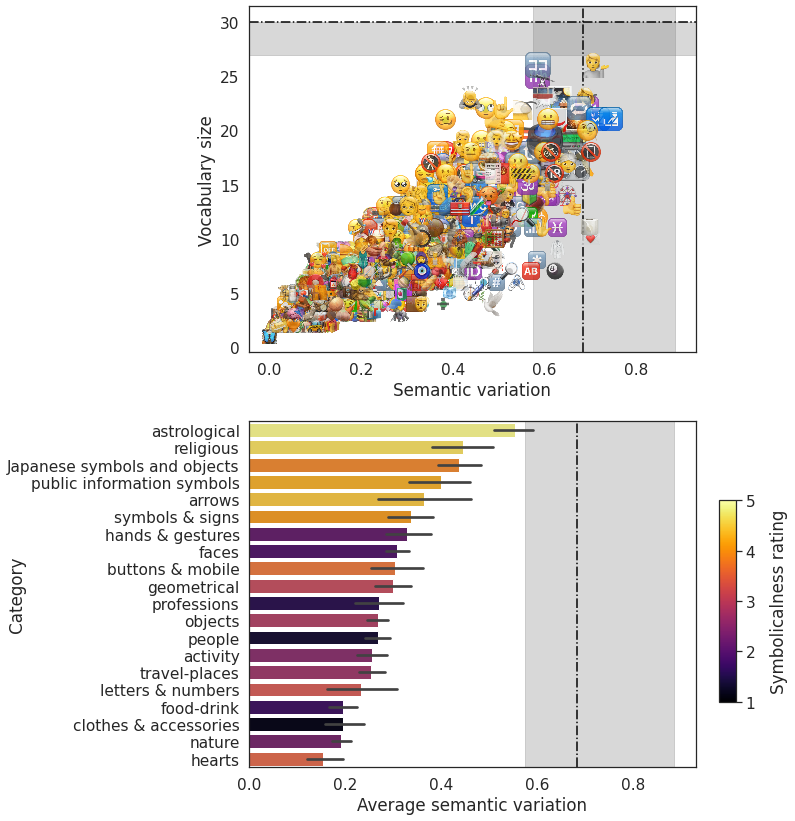

In [10]:
sns.set_color_codes()
sns.set(rc={'figure.figsize':(8, 14)}, font_scale=1.4)
sns.set_style("white", {'axes.grid' : False})

fig, axes = plt.subplots(2, 1)
df = variations
for x, y, emoji in zip(df['variation'], df['vocabulary size'], df['emoji']):
    zoom = scaler.transform([[x + y]])
    emoji_scatter(x, y, emoji, zoom=zoom, ax=axes[0], alpha=0.8)
    axes[0].scatter(x, y)

axes[0].axvline(baseline_variation, color='black', linestyle='-.')
axes[0].axvspan(baselines_var_CIs[0],
             baselines_var_CIs[1], alpha=0.3, color='gray')

axes[0].axhline(baseline_vocab, color='black', linestyle='-.')
axes[0].axhspan(baselines_vocab_size_CIs[0],
             baselines_vocab_size_CIs[1], alpha=0.3, color='gray')

axes[0].set_xlabel("Semantic variation")
axes[0].set_ylabel("Vocabulary size")

symbolicness = anns_x.merge(anns_y, on='emoji', how='left')
symbolicness['symbolicness'] = symbolicness[['is_a_symbol_x', 'is_a_symbol_y']].mean(axis=1)
symbolicness = symbolicness.merge(variations[['emoji', 'variation']], how='left', on='emoji')
symbolicness = symbolicness.dropna(subset=['variation'])

spearmanr(symbolicness.symbolicness.values, symbolicness.variation.values)

variations["category"] = variations.emoji.apply(assign_emojipedia_category)
variations["category"] = variations.apply(assign_our_category, axis=1)
variations = variations.replace({"symbols": "symbols & signs"})

data = symbolicness.groupby("category").symbolicness.mean().sort_values(ascending=False)
palette = sns.color_palette("inferno", len(data))
rank = data.argsort().argsort()

order1 = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

sns.barplot(y='category', x='variation', data=variations, ax=axes[1],\
            order=order1, palette=np.array(palette)[rank[order1]])
axes[1].set_ylabel("Category")
axes[1].set_xlabel("Average semantic variation")

axes[1].axvline(baseline_variation, color='black', linestyle='-.')
axes[1].axvspan(baselines_var_CIs[0],
                baselines_var_CIs[1], alpha=0.3, color='gray')
axes[1].yaxis.set_label_coords(-.5, .5)

# Colorbar settings
norm = plt.Normalize(1, 5)#x  #y   #width #length
cbar_ax = fig.add_axes([0.94, 0.19, 0.03, 0.2])
scalar_colormap = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
cbar = fig.colorbar(scalar_colormap, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Symbolicalness rating', rotation=90);

plt.savefig('../figures/figure1.pdf', bbox_inches='tight');

In [11]:
spearmanr(variations.variation.values, variations["vocabulary size"].values, nan_policy='omit')

SpearmanrResult(correlation=0.8421957484971772, pvalue=0.0)

### Table 1: Emoji categorization

In [16]:
categories_descriptions = pd.DataFrame([
["objects", "household items, celebrations, stationery, and miscellaneous objects"],
["nature", "scenery, animals, plants, weather"],
["travel-places", "buildings, vehicles, landscapes"],
["food-drink", "fruit, vegetables, meals, beverages and utensils"],
["faces", "smileys and faces with their cat versions"],
["people",  "anthropomorphic emojis other than professions"],
["activity",  "sports, music, the arts, hobbies, other activities, and objects associated with them"],
["clothes & accessories", "umbrellas, shoes, purses, traditional clothing"],
["symbols & signs",  "mathematical symbols, currencies, cards suit, punctuation marks"], 
["professions", "anthropomorphic emojis representing professions such as doctor and lawyer"],
["geometrical", "shapes of different sizes and colors such as large blue circle and orange diamond"],
["hands & gestures",  "gestures or activities done with hands such as folded hands and writing hands"],
["Japanese symbols and objects" , "emojis originating in Japanese culture"],
["buttons & mobile", "buttons used in mobile phones"],
["public information symbols", "danger warning, priority prohibitive, facilities, or service signs"],
["letters & numbers", "letters, numbers and their combinations"], 
["hearts",  "hearts of different colours"],
["arrows", "arrows pointing in different directions"],
["astrological", "astrological zodiac signs"],
["religious", "symbols of major religious groups"]], columns=['category', 'description']).set_index("category")

In [13]:
df1 = variations.groupby("category").emoji.count().sort_values(ascending=False)\
            .to_frame().rename({"emoji": "Number"}, axis=1)

In [14]:
df2 = variations.groupby("category").emoji.apply(list).apply(lambda x: random.choices(x, k=3))\
            .to_frame().rename({"emoji": "Examples"}, axis=1)

In [24]:
with pd.option_context('display.max_colwidth', None):
    display(df1.join(df2).join(categories_descriptions))

,Number,Examples,description
category,,,
objects,202,"[📓, 🧷, 🤿]","household items, celebrations, stationery, and miscellaneous objects"
nature,189,"[🦙, 💥, 🐢]","scenery, animals, plants, weather"
travel-places,129,"[⛩️, 🛳️, 🕌]","buildings, vehicles, landscapes"
food-drink,113,"[🧀, 🥄, 🍷]","fruit, vegetables, meals, beverages and utensils"
faces,111,"[😯, 🥶, 😺]",smileys and faces with their cat versions
people,103,"[👬, 🤵, 👄]",anthropomorphic emojis other than professions
activity,78,"[🥅, 🏸, 🎟️]","sports, music, the arts, hobbies, other activities, and objects associated with them"
clothes & accessories,47,"[🧶, ⛑️, 🧤]","umbrellas, shoes, purses, traditional clothing"
symbols & signs,43,"[✳️, ✳️, ♦️]","mathematical symbols, currencies, cards suit, punctuation marks"
